# 选择数据集

选择泰坦尼克号数据来分析

# 提出问题
  
  1.性别对乘客生还率的影响？    
  2.舱位等级对生还率的影响？  
  3.年龄对生还率的影响？  
  4.性别与舱位对生还率的共同影响？


# 数据加工
## 导入包

In [1]:
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## 载入数据

In [2]:
filename = '../p2/titanic-data.csv'
titanic_passenger_data = pd.read_csv(filename)

## 熟悉数据

*    PassengerId => 乘客ID
*    Survived => 是否生还
*    Pclass => 乘客等级(1/2/3等舱位)
*    Name => 乘客姓名
*    Sex => 性别
*    Age => 年龄
*    SibSp => 堂兄弟/妹个数
*    Parch => 父母与小孩个数
*    Ticket => 船票信息
*    Fare => 票价
*    Cabin => 船舱门牌号
*    Embarked => 登船港口

In [3]:
# 查看前5行数据，了解数据的信息，及格式
titanic_passenger_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 查看数据的统计信息
titanic_passenger_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


根据以上信息可知：  
1.船上总共有891名乘客  
2.乘客平均年龄在30岁左右，比较年轻  
3.平均生还率在38%左右  
4.年龄与船舱门牌号数据有缺失

## 数据清洗

In [5]:
# 查看数据的缺失情况
titanic_passenger_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

从上可知：  
1.年龄缺失数据117条  
2.船舱门牌号缺失数据687条  
3.登船港口缺失数据2条

年龄数据在分析中要用到，因此要对其缺失值做处理

Age：$\frac{117}{891} = 0.1987 $  

1.Age缺失值占总数据将近20%,用部分删除法(Partial Deletion)不适合

2.Age可能是影响生还率的原因之一，所以如果是空值会影响统计结果，因此选择均值插补法(Mean Imputation)，在年龄缺失处，插补其他年龄数据的均值

In [6]:
# 获取平均年龄
passenger_mean_age = titanic_passenger_data['Age'].mean()

# 用平均年龄填充缺失值
titanic_passenger_data.fillna(passenger_mean_age, inplace = True)
# 查看填充情况
titanic_passenger_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 数据探索

生还率 = 生还人数 / 乘客数  
性别、年龄、舱位都需要按照不同分组用到生还率计算，因此写成函数，方便调用，不用重复写代码

In [7]:
# 获取生还乘客的数据
survived_passenger_df = titanic_passenger_data[titanic_passenger_data.Survived == 1]

In [8]:
# 按照name对乘客进行分组后，计算每组的人数 
def group_passenger_count(data,name):
    # 按照name对乘客进行分组后，每个组的人数
    return data.groupby(name)['PassengerId'].count()

# 计算每个组的生还率    
def group_passenger_survival_rate(name):
    # 按照name对全体乘客进行分组后，每个组的人数
    group_all_passenger_count = group_passenger_count(titanic_passenger_data,name)
    # 按照name对生还乘客进行分组后，每个组的人数
    group_survived_passenger_count = group_passenger_count(survived_passenger_df,name)
    # 每个组的生还率
    return group_survived_passenger_count/group_all_passenger_count

# 输出饼图
def print_pie(group_data,title):
    # 按照name对乘客进行分组后，每个组的人数
    group_data.plot.pie(title=title,figsize=(6, 6),autopct='%3.1f%%',startangle = 90,legend=True)
    
# 输出柱状图
def print_bar(data,title):
    bar=data.plot.bar(title=title)
    for p in bar.patches:
        bar.annotate('%3.1f%%' % (p.get_height()*100), (p.get_x() * 1.005, p.get_height() * 1.005))

## 性别对生还率的影响

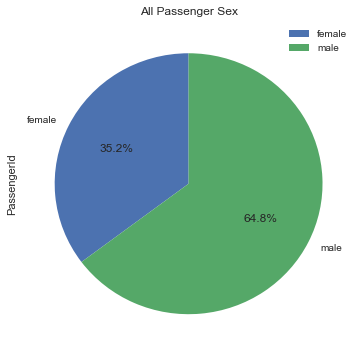

In [9]:
# 全部乘客的性别比例
print_pie(group_passenger_count(titanic_passenger_data,'Sex'),'All Passenger Sex')

为了研究性别对生还率的区别，需要先计算出，泰坦尼克号未出事前，所有乘客中，女性乘客、男性乘客所占比例，女性占35.2%，男性占64.8%

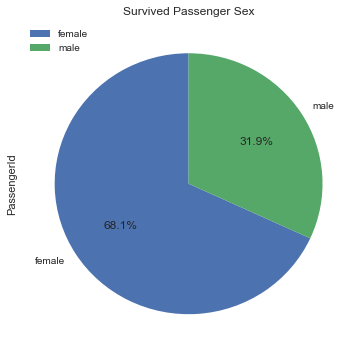

In [10]:
# 生还乘客的性别比例
print_pie(group_passenger_count(survived_passenger_df,'Sex'),'Survived Passenger Sex')

再计算出，出事后，生还的男女比例,女性占68.1%，男性占31.9%

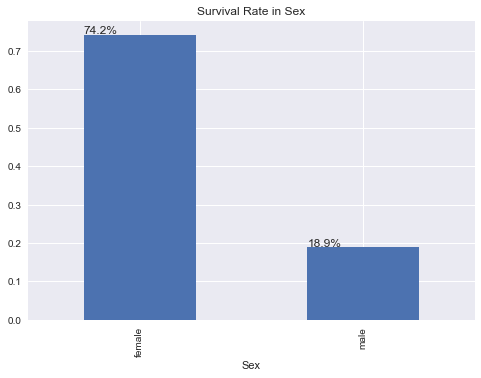

In [11]:
# 不同性别的生还率
print_bar(group_passenger_survival_rate('Sex'),'Survival Rate in Sex')

最后，分别计算出，女性与男性的生还率，制作柱状图，可视化比较，可以看出，女性生还率74.2%，男性生还率18.9%

## 年龄对生还率的影响

年龄是连续变量，直接画出直方图，很难阅读，选择将其转为分类变量，新建年龄段，将乘客按年龄段分类

In [12]:
# 每10岁一组，上限80岁
bins = np.arange(0, 80,10)
# 数据集新增年龄分组字段‘Age_group’
titanic_passenger_data['Age_group'] = pd.cut(titanic_passenger_data['Age'], bins)
# 求分组后的生还率
by_age = titanic_passenger_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 10]     0.593750
(10, 20]    0.382609
(20, 30]    0.334152
(30, 40]    0.445161
(40, 50]    0.383721
(50, 60]    0.404762
(60, 70]    0.235294
Name: Survived, dtype: float64

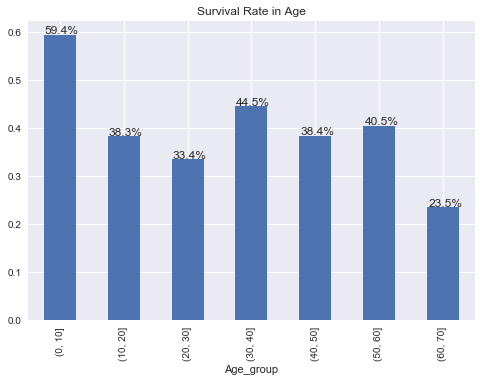

In [13]:
print_bar(by_age,'Survival Rate in Age')

将年龄分为每10岁为一组，容易阅读，可以提供有效信息，从上面数据可以看出：  
1.0-10岁，30-40岁，50-60岁的生还率比较高，都在40%以上，其中0-10岁最高，达到59.4%  
2.60-70岁的生还率最低,只有23.5%

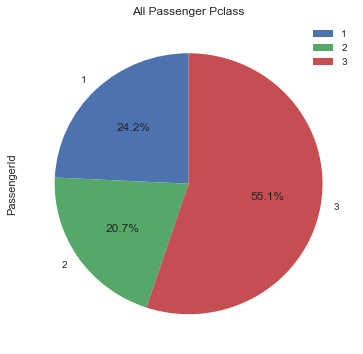

In [14]:
# 全部乘客的舱位比例
print_pie(group_passenger_count(titanic_passenger_data,'Pclass'),'All Passenger Pclass')

1代表一等舱，2代表二等舱，3代表三等舱，通过饼状图，可以清晰的看出不同舱位的乘客分布情况

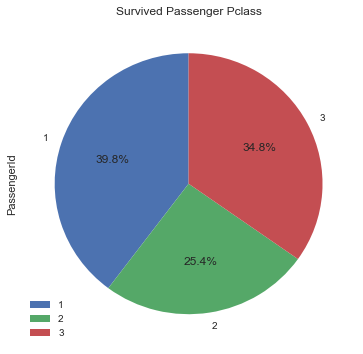

In [15]:
# 生还的乘客的舱位比例
print_pie(group_passenger_count(survived_passenger_df,'Pclass'),'Survived Passenger Pclass')

最终生还的不同舱位的乘客分布情况，与上一个饼状图对比，可以看出，一等舱的生还率最高，三等舱的生还率最低，二等舱的差不多

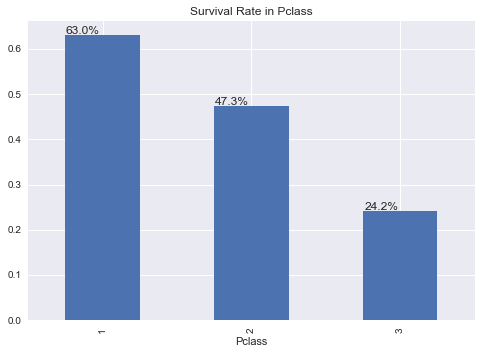

In [16]:
# 不同舱位的生还率
print_bar(group_passenger_survival_rate('Pclass'),'Survival Rate in Pclass')

从中可以看出：  
1.三等舱乘客最多，占56.1%  
2.一等舱生还率最高，占63%，三等舱生还率最低，只有24.3%，二等舱生还率是 47.3%

# 性别与舱位对生还率的共同影响

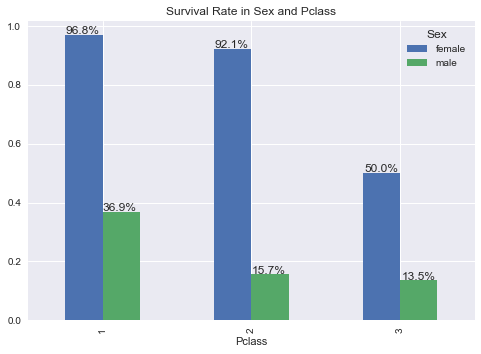

In [17]:
# 按性别和舱位分组
by_class_sex = titanic_passenger_data.groupby(['Pclass','Sex'])['Survived'].mean()

# 不同性别和舱位的生还率
print_bar(by_class_sex.unstack(),'Survival Rate in Sex and Pclass')


分别按性别、舱位等级分组后，可以清晰看出性别、舱位等级对生还率的影响，一等舱的生还率与二等舱的生还率接近，三等舱的生还率最低，同时，女性生还率明显比男性高

# 结论

通过分析，可知  
1.对生还率影响最大的是性别，女性相对男性而言，身体不够强壮，在竞争逃生船只过程中，肯定处于下风，然而，数据显示，女性的生还率远远高于男性，显然，男性在其中扮演了一个非常正面的形象，展现了良好的风度，把逃生机会更多地让给了女性，值得我们献上敬意。  
2.舱位等级也极大地影响了生还率，一等舱与二等舱的生还率要明显高于三等舱，估计是一等舱、二等舱的位置更好，遇到灾难，得到消息的时间更快，逃生通道也更方便  
3.年龄对生还率的影响最低，然而，从中还是可以看出一些规律，0-10岁的幼儿，50-60岁的老年人生还率都非常高，说明，在船上乘客们还发扬了尊老爱幼的精神


## 分析的局限性

1.因为没有对照组，根据所给的数据集，只能得出性别、舱位、年龄与生还率的相关性，不能得出因果关系  
2.年龄用均值填充了将近20%的缺失值，可能会导致对年龄影响生还率的误差较大  
3.除了给到的数据，可能影响生还率的其他因素无法考量，比如身体素质、职业等